# Multivariate time series analysis using VAR model

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('ma_lga_12345.csv')

In [3]:
df=df[df.type=='house']# Taking house type only
df['saledate'] = pd.to_datetime(df['saledate'])
df.tail()

,saledate,price,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [4]:
#Pivot the data so we can feed it into the model
df=df.pivot(index='saledate', columns='bedrooms', values='price').interpolate(method='linear', limit_direction='both')
df.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


<AxesSubplot:xlabel='saledate'>

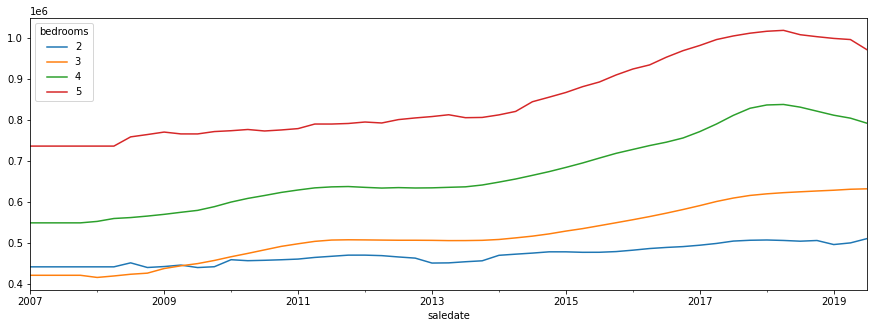

In [5]:

%matplotlib inline 
df.plot(figsize=(15,5))

<AxesSubplot:xlabel='saledate'>

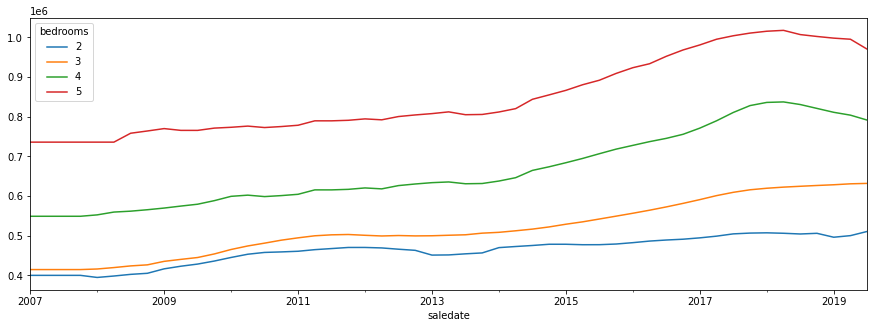

In [6]:
# To remove overlapping between 2 and 3 bedroom lines
def separate_series(df):
    columns = list(df) 
    for col in columns: 
        if col== columns[-1]:
            break

        diff_mean= (df[col+1][:-int(len(df)/3)]-df[col][:-int(len(df)/3)]).mean()
    
        df.loc[df[col] > df[col+1]-diff_mean, col] = df[col+1]-diff_mean
    return df
df=separate_series(df)
df.plot(figsize=(15,5))

In [7]:
ad_fuller_result_1 = adfuller(df.iloc[:,0])
print('2 bedroom')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')


ad_fuller_result_2 = adfuller(df.iloc[:,1])
print('3 bedroom')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')
                              
ad_fuller_result_3 = adfuller(df.iloc[:,2])
print('4 bedroom')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')    

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df.iloc[:,3])
print('5 bedroom')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')                              

2 bedroom
ADF Statistic: -1.1440025622320202
p-value: 0.6972091827484805

---------------------

3 bedroom
ADF Statistic: -1.2622572558987908
p-value: 0.6462580092174761

---------------------

4 bedroom
ADF Statistic: -1.518257611488749
p-value: 0.5244610046345944

---------------------

5 bedroom
ADF Statistic: -2.990261434959391
p-value: 0.035813922791437754


In [8]:
ad_fuller_result_1 = adfuller(df.iloc[:,0].diff()[1:])
print('2 bedroom')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')


ad_fuller_result_2 = adfuller(df.iloc[:,1].diff()[1:])
print('3 bedroom')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')
                              
ad_fuller_result_3 = adfuller(df.iloc[:,2].diff()[1:])
print('4 bedroom')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')    

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df.iloc[:,3].diff()[1:])
print('5 bedroom')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')   

2 bedroom
ADF Statistic: -3.982794762183998
p-value: 0.001503331441177173

---------------------

3 bedroom
ADF Statistic: -3.03362965221895
p-value: 0.031870943772128874

---------------------

4 bedroom
ADF Statistic: -3.03362965221895
p-value: 0.031870943772128874

---------------------

5 bedroom
ADF Statistic: -3.03362965221895
p-value: 0.031870943772128874


In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(df,-1,1).eig

array([0.40292351, 0.16715847, 0.09216369, 0.00183796])

In [10]:
#Split the data into train and test
train = df[:int(0.9*(len(df)))]
test = df[int(0.9*(len(df))):]

#Fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, freq='Q-DEC')
model_fit = model.fit()

#Forecast based on train data
forecast = model_fit.forecast(model_fit.endog, steps=len(test))

In [11]:
#Converting forecast data to a dataframe
cols = df.columns
pred = pd.DataFrame(index=test.index, data=forecast,columns=[cols])
pred=pred.astype(int)
pred.tail(6)

bedrooms,2,3,4,5
saledate,,,,
2018-06-30,507275,625404,848597,1030278
2018-09-30,507480,631399,861752,1045546
2018-12-31,507833,637650,875549,1061382
2019-03-31,508310,644176,890014,1077831
2019-06-30,508891,650995,905172,1094935
2019-09-30,509559,658120,921046,1112734


In [12]:
test.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


<AxesSubplot:xlabel='saledate'>

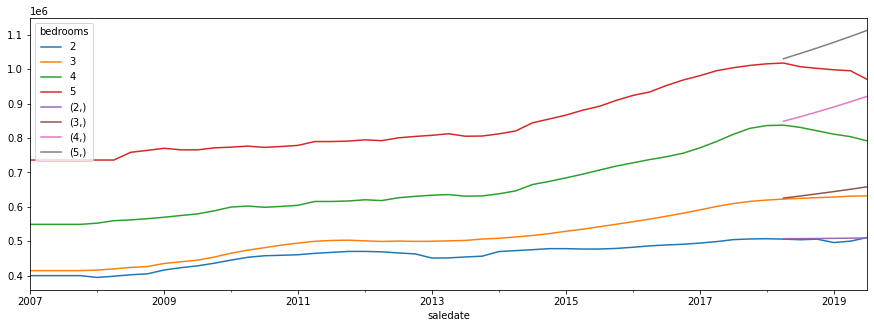

In [13]:
#Ploting actuals (df) and forecast (pred) on the same chart
ax = df.plot()
pred.plot(ax=ax,figsize=(15,5))


In [14]:
#MAPE
import numpy as np
for col in df.columns:
    print (str(col) +' bedrooms ' + str(np.mean(np.abs((df[col].iloc[-len(pred):].values - pred[[col]].values) / df[col].iloc[-len(pred):].values)) * 100))

2 bedrooms 1.027963025803897
3 bedrooms 2.3523955523069557
4 bedrooms 8.347488048618313
5 bedrooms 7.229671356483708


In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_2=sqrt(mean_squared_error(test.iloc[:,0],pred.iloc[:,0]))
rmse_3=sqrt(mean_squared_error(test.iloc[:,1],pred.iloc[:,1]))
rmse_4=sqrt(mean_squared_error(test.iloc[:,2],pred.iloc[:,2]))
rmse_5=sqrt(mean_squared_error(test.iloc[:,3],pred.iloc[:,3]))

print('2 bedrooms rmse',rmse_2)
print('3 bedrooms rmse',rmse_3)
print('4 bedroom rmse',rmse_4)
print('5 bedroom rmse',rmse_5)
    



2 bedrooms rmse 6332.084648834063
3 bedrooms rmse 15921.613255781169
4 bedroom rmse 78893.80722633854
5 bedroom rmse 83350.98694276711


In [16]:
test.iloc[:,3].mean()

998492.6666666666

<AxesSubplot:xlabel='saledate'>

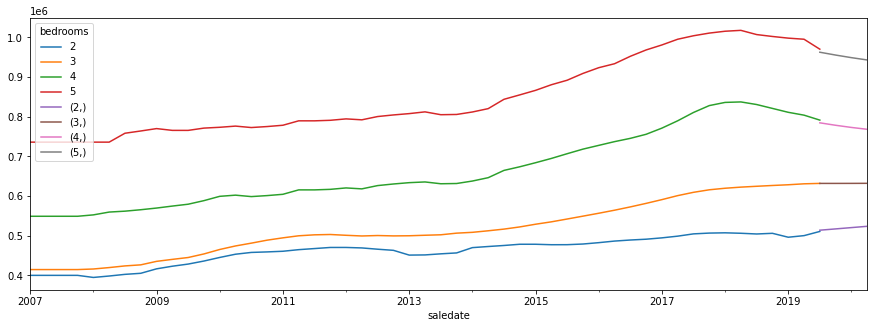

In [17]:
#Forecast actuals
model = VAR(endog=df, freq='Q-DEC')
model_fit = model.fit()
forecast_period=4
prediction = model_fit.forecast(model_fit.endog, steps=forecast_period)
cols = df.columns
forecast_index = pd.date_range('2019-09-30', freq ='Q', periods=forecast_period) 
pred = pd.DataFrame(index=forecast_index, data=prediction,columns=[cols])
ax = df.plot()
pred.plot(ax=ax,figsize=(15,5))

In [18]:
pred.shape

(4, 4)

In [19]:
pred=pred.astype(int)
pred.head()

bedrooms,2,3,4,5
2019-09-30,513849,631839,784588,962610
2019-12-31,517111,631841,778409,955461
2020-03-31,520410,631908,772959,948929
2020-06-30,523678,632060,768260,943088
